# HetRec 2011
---
The 2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011, http://ir.ii.uam.es/hetrec2011) has released datasets from Delicious, Last.fm Web 2.0, MovieLens, IMDb, and Rotten Tomatoes. These datasets contain social networking, tagging, and resource consuming (Web page bookmarking and music artist listening) information from sets of around 2,000 users.

The datasets were generated by the Information Retrieval Group at Universidad Autónoma de Madrid (http://ir.ii.uam.es). Before using these datasets, please review the README files for the usage license and other details.

---
**DATA ANALYSIS**

In [1]:
import numpy as np
import pandas as pd

import csv
import glob

from tqdm.notebook import tqdm

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import networkx as nx

# Data loading & correction
---

In [2]:
def dat_to_csv(dat_file, has_header=True, delimiter=',', save=False):
    with open(dat_file, 'r', encoding='cp437') as f:
        lines = f.read().split('\n')[:-1]
    
    if has_header:
        columns = lines[0].split(delimiter)
        lines = lines[1:]
    else:
        columns = [f'Column {i}' for i in range(len(lines[0].split(delimiter)))]
    
    df = pd.DataFrame(np.array([l.split(delimiter) for l in lines]), columns=columns)
    if save:
        df.to_csv(dat_file.replace('.dat', '.csv'))
    
    return df

## MovieLens + IMDb/Rotten Tomatoes dataset

In [3]:
df_ml_movies = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movies.dat', delimiter='\t')
df_ml_tags = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/tags.dat', delimiter='\t')
df_ml_moviegenres = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/movie_genres.dat', delimiter='\t')
df_ml_usertagged = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_taggedmovies-timestamps.dat', delimiter='\t')
df_ml_userrated = dat_to_csv('hetrec2011/hetrec2011-movielens-2k-v2/user_ratedmovies-timestamps.dat', delimiter='\t')

In [4]:
df_ml_movies = df_ml_movies[['id', 'title']]
df_ml_movies.head()

,id,title
0,1,Toy story
1,2,Jumanji
2,3,Grumpy Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [5]:
df_ml_tags.head()

,id,value
0,1,earth
1,2,police
2,3,boxing
3,4,painter
4,5,whale


In [6]:
df_ml_moviegenres.head()

,movieID,genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


In [7]:
df_ml_usertagged = df_ml_usertagged[['userID', 'movieID', 'tagID']]
df_ml_usertagged.head()

,userID,movieID,tagID
0,75,353,5290
1,78,4223,5264
2,127,1343,1544
3,127,1343,12330
4,127,2080,1451


In [8]:
df_ml_userrated = df_ml_userrated[['userID', 'movieID', 'rating']]
df_ml_userrated.head()

,userID,movieID,rating
0,75,3,1
1,75,32,4.5
2,75,110,4
3,75,160,2
4,75,163,4


In [9]:
print(f'Movies: {len(df_ml_movies)}')
print(f'Tags: {len(df_ml_tags)}')
print(f'Genres: {len(df_ml_moviegenres)}')
print(f'Movie user taggings: {len(df_ml_usertagged)}')
print(f'Movie user ratings: {len(df_ml_userrated)}')

Movies: 10197
Tags: 13222
Genres: 20809
Movie user taggings: 47957
Movie user ratings: 855598


### Smaller movielens dataset
Adapt and save larger Movielens data tables to .csv.

In [10]:
df_sml_movies = pd.read_csv('hetrec2011/ml-latest-small/movies.csv')
df_sml_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9120,162672,Mohenjo Daro (2016),Adventure|Drama|Romance
9121,163056,Shin Godzilla (2016),Action|Adventure|Fantasy|Sci-Fi
9122,163949,The Beatles: Eight Days a Week - The Touring Y...,Documentary
9123,164977,The Gay Desperado (1936),Comedy


In [11]:
df_sml_ratings = pd.read_csv('hetrec2011/ml-latest-small/ratings.csv')
df_sml_ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [12]:
df_sml_tags = pd.read_csv('hetrec2011/ml-latest-small/tags.csv')
df_sml_tags

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765
...,...,...,...,...
1291,660,135518,meaning of life,1436680885
1292,660,135518,philosophical,1436680885
1293,660,135518,sci-fi,1436680885
1294,663,260,action,1438398078


## Last.FM dataset

In [13]:
df_lf_artists = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/artists.dat', delimiter='\t')
df_lf_tags = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/tags.dat', delimiter='\t')
df_lf_userfriends = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/user_friends.dat', delimiter='\t')
df_lf_userweightings = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/user_artists.dat', delimiter='\t')
df_lf_usertagged = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat', delimiter='\t')

In [14]:
df_lf_artists = df_lf_artists[['id', 'name']]
df_lf_artists.head()

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [15]:
df_lf_tags = df_lf_tags.rename(columns={'tagID': 'id', 'tagValue': 'value'})
df_lf_tags.head()

,id,value
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [16]:
df_lf_userfriends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [17]:
df_lf_userweightings.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [18]:
df_lf_usertagged = df_lf_usertagged[['userID', 'artistID', 'tagID']]
df_lf_usertagged.head()

,userID,artistID,tagID
0,2,52,13
1,2,52,15
2,2,52,18
3,2,52,21
4,2,52,41


In [19]:
print(f'Artists: {len(df_lf_artists)}')
print(f'Tags: {len(df_lf_tags)}')
print(f'Artist user weightings: {len(df_lf_userweightings)}')
print(f'Artist user taggings: {len(df_lf_usertagged)}')

Artists: 17632
Tags: 11946
Artist user weightings: 92834
Artist user taggings: 186479


## Movies, artists and users ids correction

Change indices data type from 'str' appropriately to 'np.int32' or 'np.float32'.

In [20]:
df_ml_userrated['userID'] = df_ml_userrated['userID'].astype(np.int32)
df_ml_userrated['movieID'] = df_ml_userrated['movieID'].astype(np.int32)
df_ml_userrated['rating'] = df_ml_userrated['rating'].astype(np.float32)

df_ml_usertagged['userID'] = df_ml_usertagged['userID'].astype(np.int32)
df_ml_usertagged['movieID'] = df_ml_usertagged['movieID'].astype(np.int32)
df_ml_usertagged['tagID'] = df_ml_usertagged['tagID'].astype(np.int32)

df_ml_movies['id'] = df_ml_movies['id'].astype(np.int32)

df_ml_tags['id'] = df_ml_tags['id'].astype(np.int32)

df_ml_moviegenres['movieID'] = df_ml_moviegenres['movieID'].astype(np.int32)

In [21]:
df_lf_usertagged['userID'] = df_lf_usertagged['userID'].astype(np.int32)
df_lf_usertagged['artistID'] = df_lf_usertagged['artistID'].astype(np.int32)
df_lf_usertagged['tagID'] = df_lf_usertagged['tagID'].astype(np.int32)

df_lf_userweightings['userID'] = df_lf_userweightings['userID'].astype(np.int32)
df_lf_userweightings['artistID'] = df_lf_userweightings['artistID'].astype(np.int32)
df_lf_userweightings['weight'] = df_lf_userweightings['weight'].astype(np.float32)

df_lf_userfriends['userID'] = df_lf_userfriends['userID'].astype(np.int32)
df_lf_userfriends['friendID'] = df_lf_userfriends['friendID'].astype(np.int32)

df_lf_artists['id'] = df_lf_artists['id'].astype(np.int32)

df_lf_tags['id'] = df_lf_tags['id'].astype(np.int32)

# Data analysis
---

## Tagclouds

In [22]:
def get_tags(df_usertagged, df_tags, tagcols=('tagID', 'id', 'value'), freq_thr=100, shuffle=True):
    df_common = df_usertagged.merge(df_tags, left_on=tagcols[0], right_on=tagcols[1])
    
    tags_list = np.array([f"#{t.replace(' ', '_')}" for t in df_common[tagcols[2]]])
    
    # reduce to tags above freq_thr value
    tags_list = most_frequent_above(tags_list, freq_thr)
    
    if shuffle:
        np.random.shuffle(tags_list)
    
    return tags_list

def most_frequent_above(tags, freq_thr=100):
    freq_dict = dict()
    for tag in tags:
        if tag not in freq_dict:
            freq_dict[tag] = 0
        freq_dict[tag] += 1
    
    top_tags = list(filter(lambda x: x[1] >= freq_thr, freq_dict.items()))
    return [tt[0] for tt in top_tags]

def generate_wordcloud(text, title, max_words=10000, save_file=None):
    wc = WordCloud(max_words=10000, height=400, width=800, stopwords=set(STOPWORDS), margin=10, random_state=1).generate(text)
    plt.figure(figsize=(14, 20))
    plt.title(title)
    plt.axis("off")
    plt.imshow(wc, interpolation='bilinear')
    if save_file:
        plt.savefig(save_file)
    plt.show()

In [23]:
lf_tags = get_tags(df_lf_usertagged, df_lf_tags)
ml_tags = get_tags(df_ml_usertagged, df_ml_tags)

genres = df_ml_moviegenres['genre'].str.lower().values

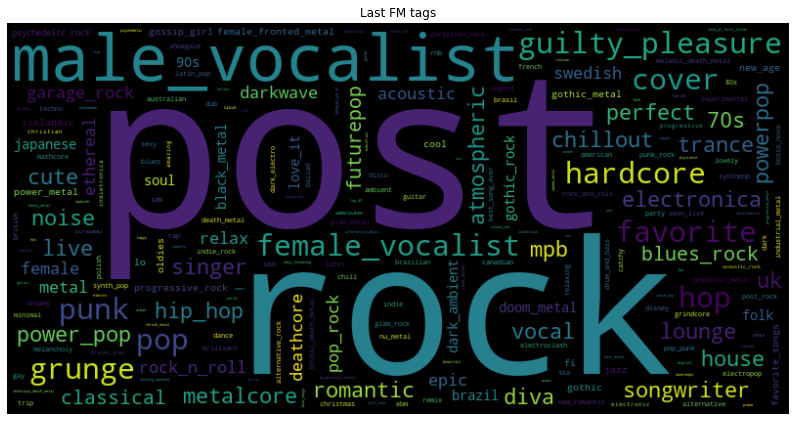

In [24]:
generate_wordcloud(' '.join(lf_tags), title='Last FM tags',
                   max_words=50000, save_file='hetrec2011/lf_tags.png')

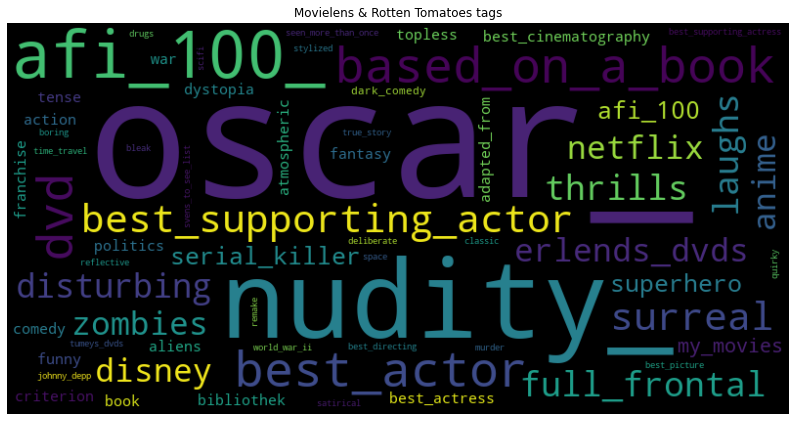

In [25]:
generate_wordcloud(' '.join(ml_tags), title='Movielens & Rotten Tomatoes tags',
                   max_words=25000, save_file='hetrec2011/ml_tags.png')

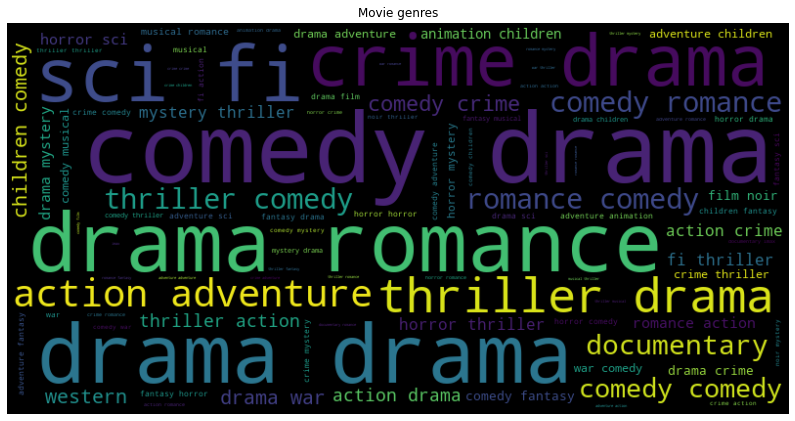

In [26]:
generate_wordcloud(' '.join(genres), title='Movie genres',
                   max_words=100, save_file='hetrec2011/genres.png')

## Common tags

In [27]:
def common_tags(s1, s2):
    return np.intersect1d(np.unique(s1), np.unique(s2))

In [28]:
n_lf_tags = np.size(np.unique(lf_tags))
n_ml_tags = np.size(np.unique(ml_tags))

In [29]:
ct = common_tags(lf_tags, ml_tags)
print(f'Common tags in music and video:\nFirst 10: {ct[:10]}\nLast 10: {ct[-10:]}')
print(f'Music tags: {n_lf_tags} | Movie tags: {n_ml_tags} | Common count: {np.size(ct)}')

Common tags in music and video:
First 10: ['#atmospheric' '#classic' '#disney']
Last 10: ['#atmospheric' '#classic' '#disney']
Music tags: 227 | Movie tags: 59 | Common count: 3


So, it is useless to compare for example movies and music using jaccard score. Almost always it would be 0. <br />
Better to vectorize all tags, calculate cosine similarity matrix for each two sets of tags and get mean score.

## User and item (movie or artist) indices

In [30]:
ml_users = np.unique(df_ml_usertagged['userID'].values)
ml_users

array([   75,    78,   127, ..., 71525, 71529, 71534], dtype=int32)

In [31]:
lf_users = np.unique(df_lf_usertagged['userID'].values)
lf_users

array([   2,    3,    4, ..., 2097, 2099, 2100], dtype=int32)

In [32]:
common_users = np.intersect1d(ml_users, lf_users)
common_users

array([  75,   78,  127,  170,  175,  190,  267,  325,  383,  476,  477,
        493,  498,  533,  545,  548,  580,  622,  636,  637,  728,  732,
        788,  922, 1017, 1035, 1047, 1118, 1122, 1160, 1164, 1174, 1198,
       1224, 1225, 1267, 1278, 1282, 1355, 1496, 1504, 1547, 1600, 1632,
       1652, 1663, 1724, 1728, 1751, 1860, 1910, 1915, 1988, 2039, 2053],
      dtype=int32)

In [33]:
print(f'These {np.size(common_users)} users of given ids were tagging movies as well as artists.\nOnly for them it is sensible to recommend movies as well as artists.')

These 55 users of given ids were tagging movies as well as artists.
Only for them it is sensible to recommend movies as well as artists.


## Tags assigned to (almost) all artists

In [34]:
df_artist_tags = df_lf_usertagged.merge(df_lf_tags, left_on='tagID', right_on='id')\
                                 .merge(df_lf_artists, left_on='artistID', right_on='id')\
                                 .drop(['userID', 'id_x', 'id_y'], axis=1)\
                                 .groupby(['tagID', 'value'])['name'].apply(np.unique)\
                                 .to_frame().reset_index().rename(columns={'name': 'artists names'})
df_artist_tags['artists count'] = [np.size(n) for n in df_artist_tags['artists names'].values]
df_artist_tags = df_artist_tags.sort_values('artists count', ascending=False)
df_artist_tags.head(10)

,tagID,value,artists names,artists count
71,73,rock,"[""Weird Al"" Yankovic, (hed) Planet Earth, +44,...",2248
23,24,pop,"[*NSYNC, 1997, 2 Brothers on the 4th Floor, 2 ...",1726
77,79,alternative,"[!!!, #####, +44, ...And You Will Know Us by t...",1718
17,18,electronic,"[!!!, 100blumen, 1200 Micrograms, 2 Brothers o...",1704
79,81,indie,"[!!!, ...And You Will Know Us by the Trail of ...",1505
122,130,female vocalists,"[3OH!3, 4 Non Blondes, 4minute, 7 Year Bitch, ...",1380
119,127,seen live,"[!!!, #####, *NSYNC, 30 Seconds to Mars, 50 Ce...",1001
32,33,experimental,"[+\-, 2 0' Clock Girlfriend, 2H Company, 3, 65...",934
38,39,dance,"[*NSYNC, 112, 2 Brothers on the 4th Floor, 2 U...",931
125,134,singer-songwriter,"[30 Seconds to Mars, 78violet, A Fine Frenzy, ...",865


## Community detection between users (based on user_friends data table)
**WILL NOT BE FINISHED FOR NOW...**

In [35]:
df_lf_userfriends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [36]:
vertices = list(np.unique(df_lf_userfriends.values.reshape(-1)))
vertices[:10]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [37]:
edges = list([tuple(u) for u in df_lf_userfriends.values])
edges[:10]

[(2, 275),
 (2, 428),
 (2, 515),
 (2, 761),
 (2, 831),
 (2, 909),
 (2, 1209),
 (2, 1210),
 (2, 1230),
 (2, 1327)]

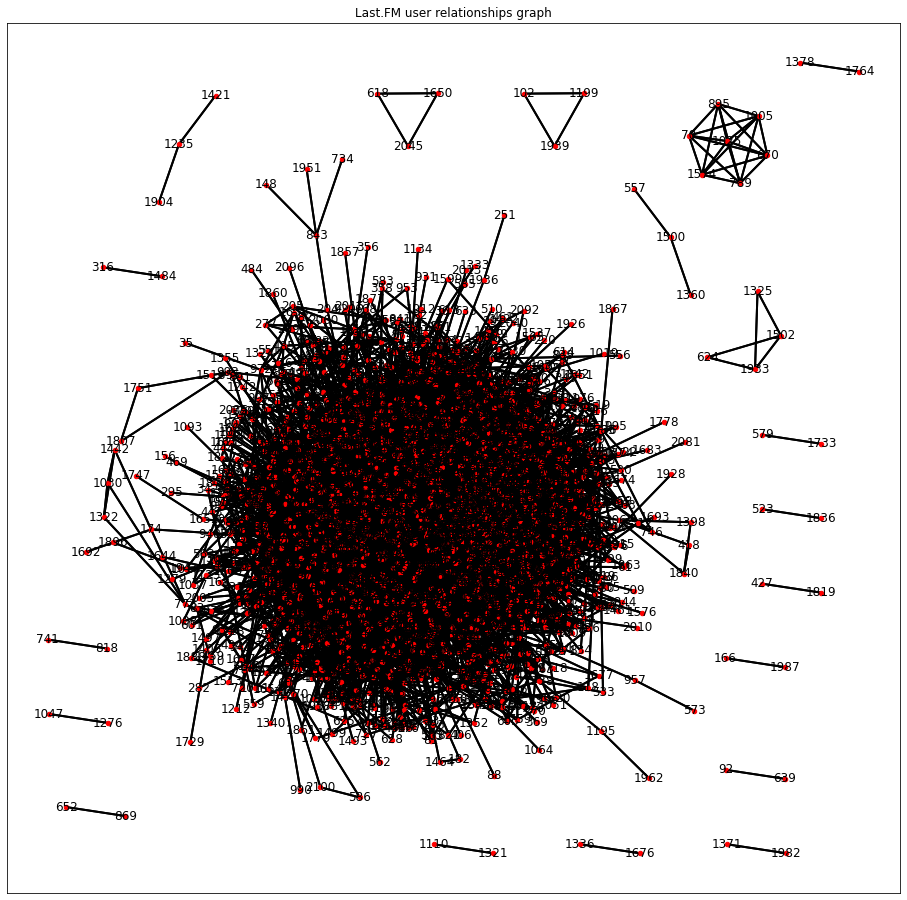

In [38]:
G = nx.Graph()
G.add_edges_from(df_lf_userfriends.values)
layout = nx.nx_pydot.graphviz_layout(G)

plt.figure(figsize=(16, 16))
nx.draw_networkx_nodes(G, pos=layout, nodelist=vertices,
                       node_color='r', node_size=20)
nx.draw_networkx_edges(G, pos=layout, edgelist=edges,
                       width=2)
nx.draw_networkx_labels(G, pos=layout, labels={v: v for v in vertices},
                        font_size=12)

plt.title('Last.FM user relationships graph')

plt.savefig('hetrec2011/lf_rel_graph.png')
plt.show()

## Movies recommendation evaluation
**TOP N HIT RATE**

In [39]:
USER01, USER02 = 190, 622

In [40]:
def top_n_hitrate(rec_true, rec_pred, n=100):
    
    hits = 0.
    for p in rec_pred[:n]:
        if p in rec_true[:n]:
            hits += 1.
    
    return hits/n

In [41]:
def evaluate_hitrate(user_id, n=1000):
    files_true = sorted(glob.glob(f'hetrec2011/evaluation_results/*{user_id}*'))
    files_pred = sorted(glob.glob(f'hetrec2011/user{user_id}_smaller*'))
    
    results = list([])
    for f_t in files_true:
        ids_true = pd.read_csv(f_t)['id'].values
        res_part = list([])
        for f_p in files_pred:
            ids_pred = pd.read_csv(f_p)['movieID'].values
            res_part.append(top_n_hitrate(ids_true, ids_pred, n))
        results.append(res_part)
    
    col_titles = [f"{f_p.split('_')[2]}" for f_p in files_pred]
    idx_titles = [f"{f_t.split('_')[1].split('/')[1]}_{f_t.split('_')[3]}" for f_t in files_true]
    df = pd.DataFrame(results, columns=col_titles, index=idx_titles)
    return df.T

In [42]:
evaluate_hitrate(USER01)

,CB_ContentKNN,CB_Random,CF_Item-KNN,CF_Random,CF_User-KNN
movie-with-artist,0.082,0.124,0.021,0.124,0.075
movie,0.097,0.110,0.009,0.110,0.061


In [43]:
evaluate_hitrate(USER02)

,CB_ContentKNN,CB_Random,CF_Item-KNN,CF_Random,CF_User-KNN
movie-with-artist,0.046,0.107,0.033,0.107,0.089
movie,0.008,0.122,0.030,0.122,0.092
